# Project 3 - Spatial Analyis and Spatial Auto-correlation
### Lorn Jaeger


In [3]:
from pathlib import Path

dpath = Path("/run/host/run/data_raid5/scratch/wsts_temp/")

files = []

for dir in sorted(dpath.iterdir()):
    if dir.is_dir():
        for file in sorted(dir.iterdir()):
            if file.is_file():
                files.append(file)

print(f"{len(files)} fires")

In [2]:
import h5py
import numpy as np
import pandas as pd

feature_names = [
    'M11', 'I2', 'I1', 'NDVI', 'EVI2',
    'precip', 'wind_speed', 'wind_dir',
    'temp_min', 'temp_max', 'ERC',
    'specific_humidity', 'slope', 'aspect',
    'elevation', 'PDSI', 'landcover',
    'forecast_precip', 'forecast_wind_speed',
    'forecast_wind_dir', 'forecast_temp',
    'forecast_specific_humidity',
    'active_fire_count'
]

rows = []

for file in files:
    with h5py.File(file, "r") as r:
        data = r["data"]                      
        dates = r["data"].attrs["img_dates"]   
        fire_id = r["data"].attrs["fire_name"]
        lon, lat = r["data"].attrs["lnglat"]     

        for i, date in enumerate(dates):
            raster = data[i]                   
    
            b23 = raster[22]
            mask = b23 != 0
            num_active = int(mask.sum())

            if num_active == 0:
                full_mask = np.ones_like(mask, dtype=bool)
            else:
                full_mask = mask

            masked_vals = raster[:22][:, full_mask]   
            means = masked_vals.mean(axis=1)

            lc_vals = raster[16][full_mask].astype(int, copy=False)
            majority_lc = np.bincount(lc_vals).argmax()
            means[16] = majority_lc

            row = list(means) + [num_active]

            rows.append({
                "fire_id": fire_id,
                "date": str(date),
                "lat": lat,
                "lon": lon,
                **{feature_names[j]: row[j] for j in range(23)}
            })

df = pd.DataFrame(rows)
df
df.to_csv("output.csv", index=False)

In [3]:
df_filled = df.copy()

num_cols = df_filled.select_dtypes(include=[np.number]).columns

global_means = df_filled[num_cols].mean()

for col in num_cols:
    fire_means = df_filled.groupby("fire_id")[col].transform("mean")
    
    fallback = global_means[col]
    col_fill = fire_means.fillna(fallback)
    
    df_filled[col] = df_filled[col].fillna(col_fill)

In [4]:
df_filled

,fire_id,date,lat,lon,M11,I2,I1,NDVI,EVI2,precip,...,aspect,elevation,PDSI,landcover,forecast_precip,forecast_wind_speed,forecast_wind_dir,forecast_temp,forecast_specific_humidity,active_fire_count
0,fire_19276074,2016-02-02,35.877374,-102.511758,3159.270020,3338.183350,2289.225830,2733.130859,1570.045044,0.000000,...,144.808441,1183.252808,4.594414,10.0,0.041336,6.846999,-68.853485,-0.712261,0.002316,0
1,fire_19276074,2016-02-03,35.877374,-102.511758,4395.890625,5438.217285,4950.474121,2733.130859,1570.045044,0.091416,...,144.808441,1183.252808,4.594414,10.0,0.267052,1.069998,-23.898361,-1.924974,0.001996,0
2,fire_19276074,2016-02-04,35.877374,-102.511758,2280.246094,2200.219971,1262.041382,2733.130859,1570.045044,0.000000,...,144.808441,1183.252808,4.486348,10.0,0.000000,4.180298,50.544056,0.817368,0.001673,0
3,fire_19276074,2016-02-05,35.877374,-102.511758,2499.521973,2622.283203,1797.539795,2733.130859,1570.045044,0.000000,...,144.808441,1183.252808,4.486348,10.0,0.084025,5.191737,-74.767525,0.062895,0.002089,0
4,fire_19276074,2016-02-06,35.877374,-102.511758,2294.578857,2249.032227,1269.090210,2733.130859,1570.045044,0.000000,...,144.808441,1183.252808,4.486348,10.0,0.000000,2.128143,20.316050,3.545615,0.002004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24457,fire_WA4872212113620230729,2023-08-22,48.741578,-121.152677,1147.666626,2336.266602,1290.733276,6655.766602,2265.366699,0.000000,...,238.505051,1344.133301,-2.842333,1.0,0.000000,0.738307,-29.431255,12.250249,0.006187,30
24458,fire_WA4872212113620230729,2023-08-23,48.741578,-121.152677,3216.137451,5220.422363,4756.203125,6954.016113,2879.695068,0.118841,...,178.313416,1315.425781,-4.174333,1.0,0.000000,0.327329,27.728411,14.858047,0.005976,0
24459,fire_WA4872212113620230729,2023-08-24,48.741578,-121.152677,782.457947,2288.259033,412.252960,6954.016113,2879.695068,0.118841,...,178.313416,1315.425781,-4.174333,1.0,0.000000,0.348034,5.166900,16.414385,0.006236,0
24460,fire_WA4872212113620230729,2023-08-25,48.741578,-121.152677,4778.750000,6766.416504,6696.750000,6921.666504,2999.333252,0.000000,...,208.607956,1434.333374,-2.773333,1.0,0.062500,0.467697,-13.238475,15.191544,0.006781,12


In [5]:
df_filled.isna().sum()
df = df_filled

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df = df_filled.copy()
df = df.sort_values(["fire_id", "date"])
df["next_day_fire"] = df.groupby("fire_id")["active_fire_count"].shift(-1)
df = df.dropna(subset=["next_day_fire"])
df["next_day_fire"] = df["next_day_fire"].astype(float)

feature_cols = df.columns.difference(["fire_id", "date", "next_day_fire"])
X = df[feature_cols]
y = df["next_day_fire"]

fires = df["fire_id"].unique()
train_fires, test_fires = train_test_split(fires, test_size=0.2, random_state=42)
train_idx = df["fire_id"].isin(train_fires)
test_idx  = df["fire_id"].isin(test_fires)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))

importances = model.feature_importances_
idx = np.argsort(importances)[::-1]
print("\nTop 20 features:")
for i in idx[:20]:
    print(f"{feature_cols[i]}: {importances[i]:.4f}")


MAE: 62.371646480254896
R²: 0.6956379769613534

Top 20 features:
active_fire_count: 0.6658
wind_dir: 0.0329
ERC: 0.0234
forecast_wind_speed: 0.0193
forecast_specific_humidity: 0.0191
wind_speed: 0.0174
M11: 0.0172
forecast_temp: 0.0169
temp_max: 0.0165
NDVI: 0.0146
PDSI: 0.0144
aspect: 0.0142
lon: 0.0139
slope: 0.0137
elevation: 0.0131
specific_humidity: 0.0123
precip: 0.0111
temp_min: 0.0110
EVI2: 0.0108
I2: 0.0102


In [7]:
df['next_day_fire'].describe()


count    23458.000000
mean       111.737957
std        312.479667
min          0.000000
25%          0.000000
50%          4.000000
75%         81.000000
max       9134.000000
Name: next_day_fire, dtype: float64

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df = df_filled.copy()
df = df.sort_values(["fire_id", "date"])
df["next_day_fire"] = df.groupby("fire_id")["active_fire_count"].shift(-1)
df = df.dropna(subset=["next_day_fire"])
df["next_day_fire"] = df["next_day_fire"].astype(float)

# log-transform target
df["target_log"] = np.log1p(df["next_day_fire"])

feature_cols = df.columns.difference(["fire_id", "date", "next_day_fire", "target_log"])
X = df[feature_cols]
y = df["target_log"]

fires = df["fire_id"].unique()
train_fires, test_fires = train_test_split(fires, test_size=0.2, random_state=42)
train_idx = df["fire_id"].isin(train_fires)
test_idx  = df["fire_id"].isin(test_fires)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# predict in log space → convert back
preds_log = model.predict(X_test)
preds = np.expm1(preds_log)

y_true = df.loc[test_idx, "next_day_fire"]

print("MAE:", mean_absolute_error(y_true, preds))
print("R²:", r2_score(y_true, preds))

# feature importance
importances = model.feature_importances_
idx = np.argsort(importances)[::-1]
print("\nTop 20 features:")
for i in idx[:20]:
    print(f"{feature_cols[i]}: {importances[i]:.4f}")


MAE: 53.37723470878723
R²: 0.6497351279521257

Top 20 features:
active_fire_count: 0.6344
precip: 0.0336
NDVI: 0.0203
forecast_wind_speed: 0.0196
forecast_specific_humidity: 0.0190
slope: 0.0186
wind_speed: 0.0172
wind_dir: 0.0172
lon: 0.0160
PDSI: 0.0160
I2: 0.0155
ERC: 0.0155
forecast_temp: 0.0149
temp_max: 0.0148
forecast_wind_dir: 0.0148
M11: 0.0144
elevation: 0.0133
lat: 0.0124
I1: 0.0122
temp_min: 0.0120


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# True and predicted values for test fires
test_df = df.loc[test_idx].copy()
test_df["pred"] = preds

results = []
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df = df_filled.copy()
df = df.sort_values(["fire_id", "date"])
df["next_day_fire"] = df.groupby("fire_id")["active_fire_count"].shift(-1)
df = df.dropna(subset=["next_day_fire"])
df["next_day_fire"] = df["next_day_fire"].astype(float)

# log-transform target
df["target_log"] = np.log1p(df["next_day_fire"])

feature_cols = df.columns.difference(["fire_id", "date", "next_day_fire", "target_log"])
X = df[feature_cols]
y = df["target_log"]

fires = df["fire_id"].unique()
train_fires, test_fires = train_test_split(fires, test_size=0.2, random_state=42)
train_idx = df["fire_id"].isin(train_fires)
test_idx  = df["fire_id"].isin(test_fires)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# predict in log space → convert back
preds_log = model.predict(X_test)
preds = np.expm1(preds_log)

y_true = df.loc[test_idx, "next_day_fire"]

print("MAE:", mean_absolute_error(y_true, preds))
print("R²:", r2_score(y_true, preds))

# feature importance
importances = model.feature_importances_
idx = np.argsort(importances)[::-1]
print("\nTop 20 features:")
for i in idx[:20]:
    print(f"{feature_cols[i]}: {importances[i]:.4f}")
for fire_id, g in test_df.groupby("fire_id"):
    y_true = g["next_day_fire"].values
    y_pred = g["pred"].values

    mae = mean_absolute_error(y_true, y_pred)

    # Handle fires with no variance (R² undefined)
    if y_true.std() == 0:
        r2 = np.nan
    else:
        r2 = r2_score(y_true, y_pred)

    results.append({
        "fire_id": fire_id,
        "num_days": len(g),
        "mean_true": y_true.mean(),
        "median_true": np.median(y_true),
        "max_true": y_true.max(),
        "mae": mae,
        "r2": r2
    })

fire_perf = pd.DataFrame(results)
fire_perf = fire_perf.sort_values("r2")
fire_perf.head(20)


,fire_id,num_days,mean_true,median_true,max_true,mae,r2
180,fire_NM3133910881020220304,36,0.361111,0.0,13.0,5.586512,-5.944656
136,fire_25205312,20,0.200000,0.0,4.0,1.474022,-2.779503
135,fire_25205306,20,0.200000,0.0,4.0,1.417288,-2.589344
128,fire_24695532,18,0.388889,0.0,7.0,1.788140,-0.878648
113,fire_24333267,8,0.500000,0.0,4.0,1.384138,-0.714145
153,fire_25411827,19,27.315789,4.0,320.0,41.367868,-0.693601
171,fire_KS3886709637220220409,18,184.611111,57.0,599.0,191.919779,-0.661557
87,fire_23493978,18,9.111111,9.5,29.0,6.026166,-0.618733
36,fire_21615465,14,0.285714,0.0,4.0,0.893158,-0.601478
80,fire_23300668,13,64.230769,46.0,370.0,52.132349,-0.593690


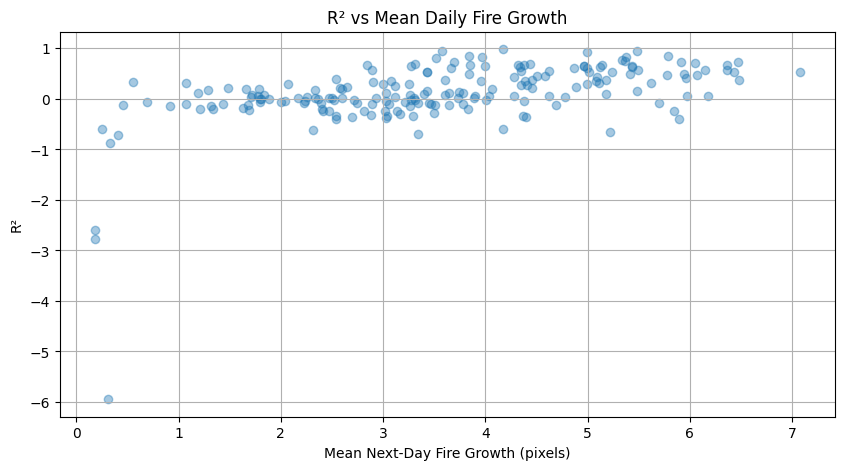

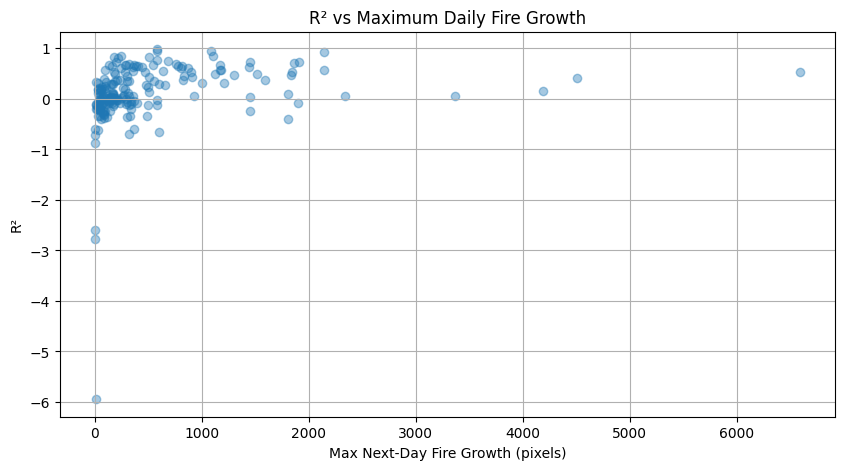

In [10]:
import matplotlib.pyplot as plt

# Drop NA R² (fires with no variance)
plot_df = fire_perf.dropna(subset=["r2"])

plt.figure(figsize=(10, 5))
plt.scatter(np.log1p(plot_df["mean_true"]), plot_df["r2"], alpha=0.4)
plt.xlabel("Mean Next-Day Fire Growth (pixels)")
plt.ylabel("R²")
plt.title("R² vs Mean Daily Fire Growth")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(plot_df["max_true"], plot_df["r2"], alpha=0.4)
plt.xlabel("Max Next-Day Fire Growth (pixels)")
plt.ylabel("R²")
plt.title("R² vs Maximum Daily Fire Growth")
plt.grid(True)
plt.show()


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ----------------------------------------------------------
# 1. Prepare dataframe (assumes df_filled already exists)
# ----------------------------------------------------------
df = df_filled.copy()
df = df.sort_values(["fire_id", "date"])

# Build target: next-day growth
df["next_day_fire"] = df.groupby("fire_id")["active_fire_count"].shift(-1)
df = df.dropna(subset=["next_day_fire"])
df["next_day_fire"] = df["next_day_fire"].astype(float)

# ----------------------------------------------------------
# 2. Spatial binning (2° x 2° bins)
# ----------------------------------------------------------
df["lat_bin"] = (df["lat"] // 2).astype(int)
df["lon_bin"] = (df["lon"] // 2).astype(int)
df["spatial_bin"] = df["lat_bin"].astype(str) + "_" + df["lon_bin"].astype(str)

# ----------------------------------------------------------
# 3. Spatial + temporal ordering of bins
# ----------------------------------------------------------
bin_start_date = df.groupby("spatial_bin")["date"].min()
ordered_bins = bin_start_date.sort_values().index

cut = int(len(ordered_bins) * 0.8)
train_bins = set(ordered_bins[:cut])
test_bins  = set(ordered_bins[cut:])

train_idx = df["spatial_bin"].isin(train_bins)
test_idx  = df["spatial_bin"].isin(test_bins)

# ----------------------------------------------------------
# 4. Feature matrix
# ----------------------------------------------------------
feature_cols = df.columns.difference(
    ["fire_id", "date", "next_day_fire", "spatial_bin", "lat_bin", "lon_bin"]
)

X_train, y_train = df.loc[train_idx, feature_cols], df.loc[train_idx, "next_day_fire"]
X_test,  y_test  = df.loc[test_idx,  feature_cols], df.loc[test_idx,  "next_day_fire"]

print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}")
print(f"Train bins: {len(train_bins)}, Test bins: {len(test_bins)}")

# ----------------------------------------------------------
# 5. Train model
# ----------------------------------------------------------
model = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

# ----------------------------------------------------------
# 6. Metrics
# ----------------------------------------------------------
print("\nOverall performance:")
print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))

# ----------------------------------------------------------
# 7. Feature importances
# ----------------------------------------------------------
imps = model.feature_importances_
order = np.argsort(imps)[::-1]

print("\nTop 20 features:")
for i in order[:20]:
    print(f"{feature_cols[i]}: {imps[i]:.4f}")

# ----------------------------------------------------------
# 8. Per-fire R²: which fires are being predicted well?
# ----------------------------------------------------------
test_df = df.loc[test_idx].copy()
test_df["pred"] = preds

fire_r2 = {}
for fire in test_df["fire_id"].unique():
    sub = test_df[test_df["fire_id"] == fire]
    if len(sub) > 3:
        fire_r2[fire] = r2_score(sub["next_day_fire"], sub["pred"])

fire_r2 = pd.Series(fire_r2).sort_values()

print("\nWorst 10 fires:")
print(fire_r2.head(10))

print("\nBest 10 fires:")
print(fire_r2.tail(10))


Train rows: 21742, Test rows: 1716
Train bins: 104, Test bins: 27

Overall performance:
MAE: 52.4845926109902
R²: 0.22060330434861253

Top 20 features:
active_fire_count: 0.6678
wind_dir: 0.0404
ERC: 0.0238
wind_speed: 0.0206
forecast_specific_humidity: 0.0175
forecast_wind_speed: 0.0175
M11: 0.0160
slope: 0.0159
temp_max: 0.0150
NDVI: 0.0142
aspect: 0.0134
elevation: 0.0134
temp_min: 0.0129
PDSI: 0.0128
forecast_temp: 0.0127
lon: 0.0121
I2: 0.0117
lat: 0.0104
precip: 0.0101
specific_humidity: 0.0100

Worst 10 fires:
fire_24604832                -417.907101
fire_SD4411109928220221010   -157.521004
fire_MI4514808434720220513   -121.384094
fire_24604731                 -72.538119
fire_TX3072910023420220516    -22.863481
fire_25295966                 -19.720935
fire_23757522                 -14.320296
fire_KY3727108427720221106     -7.949422
fire_NE4194610014320220423     -6.835608
fire_25088018                  -6.571006
dtype: float64

Best 10 fires:
fire_24604783                 0.1793

In [13]:
df_filled.to_csv("filled_output.csv", index=False)
